In [1]:
import os
import sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud
from datetime import datetime, timedelta

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import mlflow
import mlflow.sklearn
import joblib

In [2]:
os.chdir('..') 

In [3]:
from src.loader import SlackDataLoader
from src.config import cfg
import src.utils as utils

Output File: slack_data.csv
Path: data\Anonymized_B6SlackExport_25Nov23\anonymized
Channel: data\Anonymized_B6SlackExport_25Nov23\anonymized\channels.json
Userfile: data\Anonymized_B6SlackExport_25Nov23\anonymized\users.json


In [4]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [5]:
slack_data_loader = SlackDataLoader(cfg.path)
user_names_by_id, user_ids_by_name = slack_data_loader.get_user_map()

In [6]:
all_channel_messages = []

for channel in slack_data_loader.channels:
    channel_name = channel['name']
    channel_messages = slack_data_loader.get_channel_messages(channel_name)

    # Add 'channel' information to each message
    for message in channel_messages:
        message['channel'] = channel_name

    all_channel_messages.extend(channel_messages)

In [7]:
# Convert the list of messages into a DataFrame
slack_data_df = pd.DataFrame(all_channel_messages)

In [8]:
slack_data_df.head()

,type,subtype,ts,user,text,channel,client_msg_id,blocks,team,user_team,...,x_files,hidden,bot_id,app_id,bot_profile,room,no_notifications,permalink,bot_link,inviter
0,message,channel_join,1660301317.785879,U03TEPYRM2P,<@U03TEPYRM2P> has joined the channel,all-community-building,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,message,channel_join,1660301593.241889,U03T89ACUUW,<@U03T89ACUUW> has joined the channel,all-community-building,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,message,channel_join,1660833152.540199,U03U9DB7REG,<@U03U9DB7REG> has joined the channel,all-community-building,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,message,channel_join,1660833720.685639,U03UKL27B0R,<@U03UKL27B0R> has joined the channel,all-community-building,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,message,channel_join,1660838313.991269,U03UL5LSTG9,<@U03UL5LSTG9> has joined the channel,all-community-building,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Download 'punkt' resource
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Apply the cleaning function to the 'text' column
slack_data_df['clean_text'] = slack_data_df['text'].apply(utils.clean_text)

In [11]:
# Remove missing values
slack_data_df = slack_data_df.dropna(subset=['clean_text'])

In [12]:
print(slack_data_df.columns)

Index(['type', 'subtype', 'ts', 'user', 'text', 'channel', 'client_msg_id',
       'blocks', 'team', 'user_team', 'source_team', 'user_profile',
       'reactions', 'thread_ts', 'reply_count', 'reply_users_count',
       'latest_reply', 'reply_users', 'replies', 'is_locked', 'subscribed',
       'parent_user_id', 'edited', 'files', 'upload', 'display_as_bot',
       'attachments', 'root', 'last_read', 'x_files', 'hidden', 'bot_id',
       'app_id', 'bot_profile', 'room', 'no_notifications', 'permalink',
       'bot_link', 'inviter', 'clean_text'],
      dtype='object')


In [13]:
print(slack_data_df)

          type       subtype                 ts         user  \
0      message  channel_join  1660301317.785879  U03TEPYRM2P   
1      message  channel_join  1660301593.241889  U03T89ACUUW   
2      message  channel_join  1660833152.540199  U03U9DB7REG   
3      message  channel_join  1660833720.685639  U03UKL27B0R   
4      message  channel_join  1660838313.991269  U03UL5LSTG9   
...        ...           ...                ...          ...   
20005  message  channel_join  1668760648.789009  U03UUS0MZCZ   
20006  message  channel_join  1668760648.854949  U03UG4Q7V42   
20007  message  channel_join  1668760648.921119  U03U9DB7REG   
20008  message  channel_join  1668760648.982879  U03UUN8M4RX   
20009  message  channel_join  1668760649.047239  U03UKL27B0R   

                                        text                 channel  \
0      <@U03TEPYRM2P> has joined the channel  all-community-building   
1      <@U03T89ACUUW> has joined the channel  all-community-building   
2      <@U03U9D

In [14]:
selected_columns = ['channel', 'text']
slack_data_df_ct = slack_data_df[selected_columns]

In [15]:
print(slack_data_df_ct)

                      channel                                   text
0      all-community-building  <@U03TEPYRM2P> has joined the channel
1      all-community-building  <@U03T89ACUUW> has joined the channel
2      all-community-building  <@U03U9DB7REG> has joined the channel
3      all-community-building  <@U03UKL27B0R> has joined the channel
4      all-community-building  <@U03UL5LSTG9> has joined the channel
...                       ...                                    ...
20005        data-engineering  <@U03UUS0MZCZ> has joined the channel
20006        data-engineering  <@U03UG4Q7V42> has joined the channel
20007        data-engineering  <@U03U9DB7REG> has joined the channel
20008        data-engineering  <@U03UUN8M4RX> has joined the channel
20009        data-engineering  <@U03UKL27B0R> has joined the channel

[20010 rows x 2 columns]


In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(slack_data_df_ct['text'], slack_data_df_ct['channel'], test_size=0.2, random_state=42)

In [17]:
# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [18]:
# Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)

MultinomialNB()

In [19]:
# Make predictions
predictions = classifier.predict(X_test_vec)

In [20]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))

Accuracy: 0.5487256371814093
                               precision    recall  f1-score   support

                ab_test-group       0.69      0.32      0.43       104
           adludios-challange       0.69      0.07      0.13       122
                all-broadcast       0.58      0.64      0.61       102
         all-career-exercises       0.48      0.24      0.32       168
       all-community-building       0.57      0.97      0.72      1650
                all-de-week12       0.00      0.00      0.00         1
                    all-ideas       0.50      0.02      0.03        60
                all-ml-week12       0.00      0.00      0.00         5
                all-resources       0.72      0.89      0.80       314
        all-technical-support       0.00      0.00      0.00        38
              all-web3-week12       0.00      0.00      0.00         3
                    all-week1       0.60      0.22      0.32       131
                   all-week10       1.00      0

C:\Users\Abel\Documents\10 Academy\10-Academy-Week-0\week0\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abel\Documents\10 Academy\10-Academy-Week-0\week0\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abel\Documents\10 Academy\10-Academy-Week-0\week0\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [21]:
# Using Latent Dirichlet Allocation (LDA) for Topic Modeling
lda = LatentDirichletAllocation(n_components=10, random_state=42)
message_topics = lda.fit_transform(X_train_vec)

In [22]:
# Log the model with MLflow
os.makedirs("mlflow_logs/artifacts", exist_ok=True)
with mlflow.start_run():
    mlflow.log_param("model_type", "NaiveBayes")
    mlflow.sklearn.log_model(classifier, "model")

    # Save vectorizer
    vectorizer_path = "mlflow_logs/artifacts/vectorizer.pkl"
    joblib.dump(vectorizer, vectorizer_path)
    mlflow.log_artifact(vectorizer_path, "artifacts")

    # Save LDA model
    lda_path = "mlflow_logs/artifacts/lda_model.pkl"
    joblib.dump(lda, lda_path)
    mlflow.log_artifact(lda_path, "artifacts")

    # Log additional information
    mlflow.log_param("accuracy", accuracy)

In [23]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Abel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [24]:
# Using NLTK's Vader Sentiment Intensity Analyzer for Sentiment Analysis
sid = SentimentIntensityAnalyzer()
slack_data_df_ct['sentiment_score'] = slack_data_df_ct['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
slack_data_df_ct['sentiment'] = slack_data_df_ct['sentiment_score'].apply(lambda x: 'positive' if x >= 0 else 'negative')

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30380\462206010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slack_data_df_ct['sentiment_score'] = slack_data_df_ct['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_30380\462206010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slack_data_df_ct['sentiment'] = slack_data_df_ct['sentiment_score'].apply(lambda x: 'positive' if x >= 0 else 'negative')


In [25]:
# Analysis of Top 10 Topics
# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_words = []
for topic_weights in lda.components_:
    top_word_idx = topic_weights.argsort()[-10:][::-1]
    topic_words.append([feature_names[i] for i in top_word_idx])

In [26]:
# Display the top words for each topic
for i, words in enumerate(topic_words):
    print(f"Topic {i + 1}: {', '.join(words)}")

Topic 1: is, it, the, this, for, was, that, what, not, my
Topic 2: https, yes, org, com, io, airflow, be, youtu, docs, kafka
Topic 3: the, has, channel, joined, in, home, py, he, file, line
Topic 4: joy, hello, the, can, you, same, one, is, it, error
Topic 5: to, we, will, be, this, the, and, it, for, are
Topic 6: to, you, that, my, are, yeah, and, the, too, am
Topic 7: the, google, meet, session, here, time, please, on, in, next
Topic 8: you, the, to, of, and, have, for, in, it, your
Topic 9: https, com, www, youtube, watch, amp, good, morning, in, blog
Topic 10: the, to, and, you, it, on, is, we, of, for


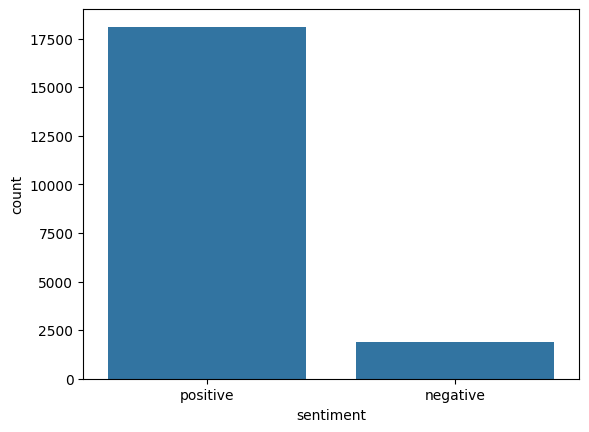

In [27]:
# Visualize the sentiment distribution
sns.countplot(x='sentiment', data=slack_data_df_ct)
plt.show()

In [28]:
slack_data_df['ts'] = utils.convert_2_timestamp('ts', slack_data_df)

In [29]:
start_date = pd.to_datetime(slack_data_df['ts']).min().date()  # Assuming the start date is the minimum date in the 'ts' column
slack_data_df['days_since_start'] = (pd.to_datetime(slack_data_df['ts']).dt.date - start_date).dt.days

In [30]:
grouped_data = slack_data_df.groupby('days_since_start')


In [31]:
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'combined_text' column
slack_data_df['sentiment'] = slack_data_df['text'].apply(analyze_sentiment)


In [32]:
# The sentiment score typically ranges from -1 to 1, where:

# Positive sentiment: A score closer to 1 indicates a more positive sentiment.
# Neutral sentiment: A score around 0 suggests a neutral sentiment.
# Negative sentiment: A score closer to -1 indicates a more negative sentiment.

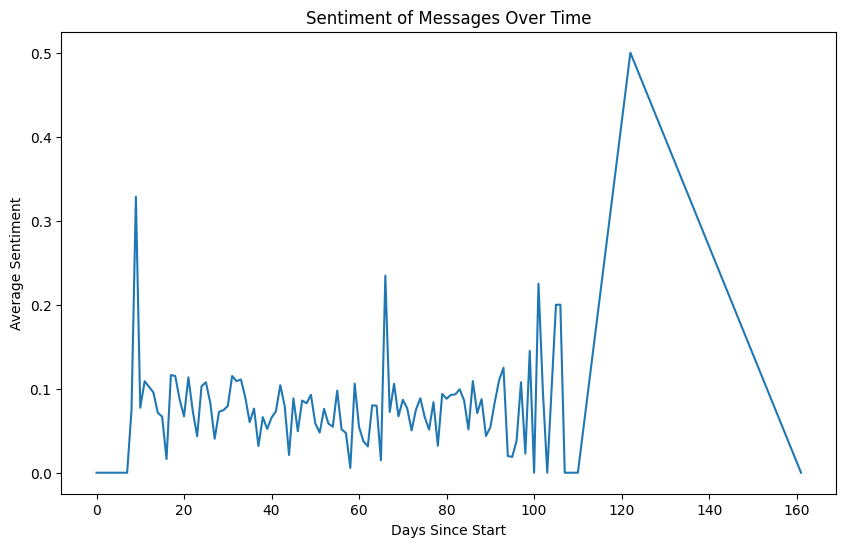

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
grouped_data['sentiment'].mean().plot(kind='line')
plt.title('Sentiment of Messages Over Time')
plt.xlabel('Days Since Start')
plt.ylabel('Average Sentiment')
plt.show()

In [34]:
#Create a 'Days Since Start' Column
start_date = pd.to_datetime(slack_data_df['ts']).min().date()  # Assuming the start date is the minimum date in the 'ts' column
slack_data_df['days_since_start'] = (pd.to_datetime(slack_data_df['ts']).dt.date - start_date).dt.days

In [35]:
grouped_data = slack_data_df.groupby('days_since_start')

In [36]:
# Initialize an empty list to store DataFrames
dfs_to_concat = []

In [37]:
for day, group in grouped_data:
    # Concatenate all messages and replies for the current day
    concatenated_text = ' '.join(group['text'].dropna())
    
    # Create a DataFrame for the current day
    day_df = pd.DataFrame({'day': [day], 'concatenated_text': [concatenated_text]})
    
    # Append the DataFrame to the list
    dfs_to_concat.append(day_df)


In [38]:
concatenated_texts_df = pd.concat(dfs_to_concat, ignore_index=True)

In [39]:
# Display the resulting DataFrame
print(concatenated_texts_df)

     day                                  concatenated_text
0      0  <@U03TEPYRM2P> has joined the channel <@U03T89...
1      6  <@U03U9DB7REG> has joined the channel <@U03UKL...
2      7  <@U03UP7V9Q57> has joined the channel <@U03UDB...
3      8  <@U03U1FNPEUX> has joined the channel <@U03U1F...
4      9  Hi all, looking forward to starting together, ...
..   ...                                                ...
100  106  <https://youtu.be/-DVyjdw4t9I|https://youtu.be...
101  107  <https://resources.biginterview.com/interview-...
102  110  Hey <!channel>, can everyone work on deploymen...
103  122  <!channel> <!here> Hello Buddies, Its my hope ...
104  161  Can one/ team enroll to <https://lablab.ai/eve...

[105 rows x 2 columns]


In [40]:
analyzer = SentimentIntensityAnalyzer()

In [41]:
# Apply sentiment analysis to each row
concatenated_texts_df['compound'] = concatenated_texts_df['concatenated_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [42]:
# Display the resulting DataFrame
print(concatenated_texts_df[['day', 'compound']])

     day  compound
0      0    0.0000
1      6    0.0000
2      7    0.0000
3      8    0.9902
4      9    0.9634
..   ...       ...
100  106    0.9200
101  107    0.0000
102  110    0.3802
103  122    0.9756
104  161    0.0000

[105 rows x 2 columns]


In [43]:
# The sentiment score typically ranges from -1 to 1, where:

# Positive sentiment: A score closer to 1 indicates a more positive sentiment.
# Neutral sentiment: A score around 0 suggests a neutral sentiment.
# Negative sentiment: A score closer to -1 indicates a more negative sentiment.

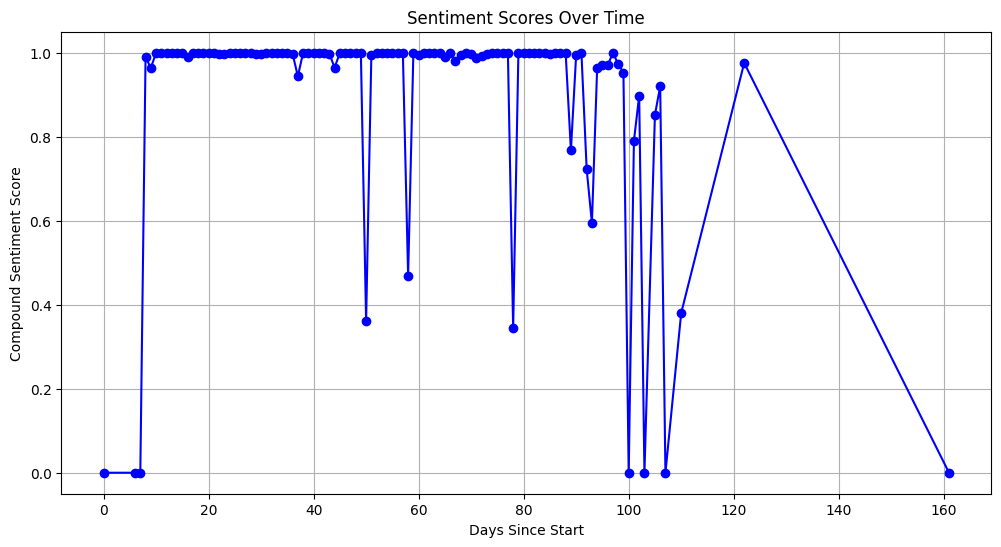

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(concatenated_texts_df['day'], concatenated_texts_df['compound'], marker='o', linestyle='-', color='b')
plt.title('Sentiment Scores Over Time')
plt.xlabel('Days Since Start')
plt.ylabel('Compound Sentiment Score')
plt.grid(True)
plt.show()